In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

from glob import glob

In [6]:
a = glob('/content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_processed/train_crop_align_2/*.jpg')

In [7]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/AI_HACKATHON_NEWBEES/data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_raw')

KeyboardInterrupt: 

# IOU

In [11]:
# Convert x1, y1, x2, y2 -> x, y, w, h (top left -> bottom right)
def convert_corr(bbox):
  x1, y1,x2, y2 = bbox
  return [x1, y1, x2-x1, y2-y1]

In [12]:
def iou(gt, pred):

	# bbox = x, y, w, h -> x, y, x+w, y+h

	gt_tmp = [gt[0], gt[1], gt[0] + gt[2], gt[1] + gt[3]]
	pred_tmp = [pred[0], pred[1], pred[0] + gt[2], pred[1] + pred[3]]

	xA = max(gt_tmp[0], pred_tmp[0])
	yA = max(gt_tmp[1], pred_tmp[1])
	xB = min(gt_tmp[2], pred_tmp[2])
	yB = min(gt_tmp[3], pred_tmp[3])

	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

	gtArea = (gt_tmp[2] - gt_tmp[0] + 1) * (gt_tmp[3] - gt_tmp[1] + 1)
	predArea = (pred_tmp[2] - pred_tmp[0] + 1) * (pred_tmp[3] - pred_tmp[1] + 1)

	iou = interArea / float(gtArea + predArea - interArea)
	return iou

In [13]:
import ast

def get_bbox_gt(filename):
  bbox_gt = single_label.loc[single_label['file_name'] == filename , 'bbox'].values[0]
  bbox_gt = ast.literal_eval(bbox_gt)
  bbox_gt = np.array(bbox_gt)
  return bbox_gt

In [14]:
def select_bbox(result, bbox_gt):
    final_result = []
    max_iou = 0.5
    best_face = None

    for face in result:
        bbox_pred = convert_corr(face[0])
        current_iou = iou(bbox_pred, bbox_gt)

        if current_iou > max_iou:
            max_iou = current_iou
            best_face = face

    if best_face is not None:
        final_result.append(best_face)

    return final_result


In [ ]:
import shutil
shutil.unpack_archive('/content/drive/MyDrive/AI_HACKATHON_NEWBEES/data.zip', '/content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_raw')

# Insight Face

In [ ]:
data_dir = '/content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_raw/public_test/'
data_crop_dir = '/content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_raw/public_test_crop/'

In [15]:
!pip install -U insightface
!pip install onnxruntime-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 36.3 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp310-cp310-linux_x86_64.whl size=1054127 sha256=607091146f436a3fb8eefb9e18d35337b40d7ea56f962ff1911b260e167c27bc
  Stored in directory: /root/.cache/pip/wheels/e3/d0/80/e3773fb8b6d1cca87ea1d33d9b1f20a223a6493c896da249b5
Successfully built insightface
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.1/157.1 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.4 MB/s eta 0:00:00


In [16]:
import cv2
import numpy as np
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image

app = FaceAnalysis(allowed_modules=['detection']) # enable detection model only
app.prepare(ctx_id=0, det_size=(640, 640))


download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:20<00:00, 13958.86KB/s]


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition
set det-size: (640, 640)


In [17]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 7.9 MB/s eta 0:00:00


## MTCNN

In [18]:
from mtcnn import MTCNN
import cv2

detector = MTCNN()

In [ ]:
face

[]

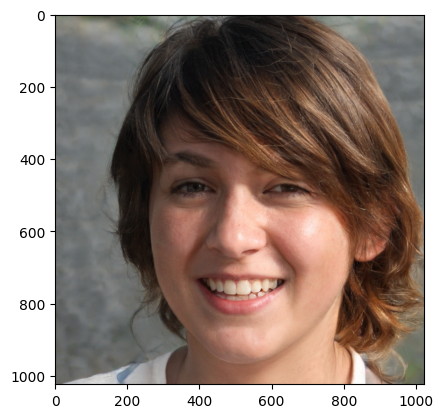

In [ ]:
img = cv2.imread('/content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_raw/public_test/image_3167.jpg')
#img = cv2.resize(img, (256,256))

faces = app.get(img)
rimg = app.draw_on(img, faces)
plt.imshow(rimg[:,:,::-1])

In [ ]:
# for face in faces:
#   print(face)

## Test crop Insight face

In [19]:
import concurrent.futures

def read_image(filename):
    dir_img = f'/content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_processed/train/{filename}'
    img = cv2.imread(dir_img)
    return img

def read_all_image(file_list):
  img_list = []
  with concurrent.futures.ThreadPoolExecutor() as executor:
      img_list = list(executor.map(read_image, file_list))
  return img_list

In [20]:
import math
from typing import Union
from PIL import Image

def findEuclideanDistance(
    source_representation: Union[np.ndarray, list], test_representation: Union[np.ndarray, list]
) -> float:
    """
    Find euclidean distance between 2 vectors
    Args:
        source_representation (numpy array or list)
        test_representation (numpy array or list)
    Returns
        distance
    """
    if isinstance(source_representation, list):
        source_representation = np.array(source_representation)

    if isinstance(test_representation, list):
        test_representation = np.array(test_representation)

    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

def alignment_procedure(img: np.ndarray, left_eye: tuple, right_eye: tuple, nose: tuple):
    """
    Alignma given face with respect to the left and right eye coordinates.
    Left eye is the eye appearing on the left (right eye of the person). Left top point is (0, 0)
    Args:
        img (numpy array): given image
        left_eye (tuple): left eye coordinates.
            Left eye is appearing on the left of image (right eye of the person)
        right_eye (tuple): right eye coordinates.
            Right eye is appearing on the right of image (left eye of the person)
        nose (tuple): coordinates of nose
    """

    left_eye_x, left_eye_y = left_eye
    right_eye_x, right_eye_y = right_eye

    # -----------------------
    # find rotation direction
    if left_eye_y > right_eye_y:
        point_3rd = (right_eye_x, left_eye_y)
        direction = -1  # rotate same direction to clock
    else:
        point_3rd = (left_eye_x, right_eye_y)
        direction = 1  # rotate inverse direction of clock

    # -----------------------
    # find length of triangle edges

    a = findEuclideanDistance(np.array(left_eye), np.array(point_3rd))
    b = findEuclideanDistance(np.array(right_eye), np.array(point_3rd))
    c = findEuclideanDistance(np.array(right_eye), np.array(left_eye))

    # -----------------------
    # apply cosine rule
    if b != 0 and c != 0:  # this multiplication causes division by zero in cos_a calculation

        cos_a = (b * b + c * c - a * a) / (2 * b * c)

        # PR15: While mathematically cos_a must be within the closed range [-1.0, 1.0],
        # floating point errors would produce cases violating this
        # In fact, we did come across a case where cos_a took the value 1.0000000169176173
        # which lead to a NaN from the following np.arccos step
        cos_a = min(1.0, max(-1.0, cos_a))

        angle = np.arccos(cos_a)  # angle in radian
        angle = (angle * 180) / math.pi  # radian to degree

        # -----------------------
        # rotate base image

        if direction == -1:
            angle = 90 - angle

        img = Image.fromarray(img)
        img = np.array(img.rotate(direction * angle))

    # -----------------------

    return img

### Extract insight face

In [21]:
def extract_insight_face(app, img):
  faces = app.get(img)
  resp = []

  expand_face_area = 2
  for face in faces:
    bbox = face['bbox']
    x = bbox[0]
    y = bbox[1]
    w = bbox[2]
    h = bbox[3]

    # expand the facial area to be extracted and stay within img.shape limits
    x1 = max(0, x - int((w * expand_face_area) / 100))  # expand left
    y1 = max(0, y - int((h * expand_face_area) / 100))  # expand top
    x2 = min(img.shape[1], w + int((w * expand_face_area) / 100))  # expand right
    y2 = min(img.shape[0], h + int((h * expand_face_area) / 100))  # expand bottom

    facial_img = img[int(y1):int(y2), int(x1):int(x2)]

    #Face alignment
    landmarks = face['kps']
    left_eye = landmarks[1]
    right_eye = landmarks[0]
    nose = landmarks[2]
    # mouth_right = landmarks["mouth_right"]
    # mouth_left = landmarks["mouth_left"]
    facial_img = alignment_procedure(facial_img, right_eye, left_eye, nose)

    result = {'facial_image': facial_img[:, :, ::-1],
            'bbox': convert_corr(bbox)}

    resp.append(result)

  return resp

### Extract mtcnn

In [22]:
detector = MTCNN()
def extract_mtcnn(detector, img):
  faces = detector.detect_faces(img)

  resp = []

  expand_face_area = 2
  for face in faces:
    bbox = face['box']
    x = bbox[0]
    y = bbox[0]
    w = bbox[0] + bbox[2]
    h = bbox[0] + bbox[3]

    # expand the facial area to be extracted and stay within img.shape limits
    x1 = max(0, x - int((w * expand_face_area) / 100))  # expand left
    y1 = max(0, y - int((h * expand_face_area) / 100))  # expand top
    x2 = min(img.shape[1], w + int((w * expand_face_area) / 100))  # expand right
    y2 = min(img.shape[0], h + int((h * expand_face_area) / 100))  # expand bottom

    facial_img = img[int(y1):int(y2), int(x1):int(x2)]

    #Face alignment
    landmarks = face['keypoints']
    left_eye = landmarks['left_eye']
    right_eye = landmarks['right_eye']
    nose = landmarks['nose']
    # mouth_right = landmarks["mouth_right"]
    # mouth_left = landmarks["mouth_left"]
    facial_img = alignment_procedure(facial_img, right_eye, left_eye, nose)

    result = {'facial_image': facial_img[:, :, ::-1],
            'bbox': bbox}

    resp.append(result)

  return resp

In [ ]:
img = cv2.imread('/content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_raw/public_test/image_94.jpg')
result = extract_mtcnn(detector, img)

6/6 [==============================] - 0s 3ms/step


In [ ]:
all_data = glob('/content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_processed/train/*.jpg')

## Bounding box estimation

In [23]:
train_labels = pd.read_csv('/content/drive/MyDrive/AI_HACKATHON_NEWBEES/labels.csv')
train_labels

,file_name,height,width,bbox,age,race,masked,skintone,emotion,gender
0,100013282.jpg,1333,2000,"[934.0000000000097, 144.82228672769534, 238.24...",20-30s,Caucasian,unmasked,mid-light,Neutral,Male
1,100016175.jpg,1333,2000,"[1094.0513571635438, 422.91772295627203, 55.45...",20-30s,Caucasian,unmasked,light,Neutral,Male
2,10004189.jpg,2000,1333,"[419.93871061403877, 269.1250391680045, 377.19...",20-30s,Mongoloid,unmasked,light,Happiness,Female
3,100104575.jpg,1333,2000,"[1490.6909678848915, 676.0000000000097, 37.553...",20-30s,Caucasian,unmasked,mid-light,Neutral,Male
4,100104600.jpg,2000,1333,"[549.169724453414, 92.52040334013152, 306.8821...",20-30s,Caucasian,unmasked,mid-light,Happiness,Female
...,...,...,...,...,...,...,...,...,...,...
15305,image_2713.jpg,1024,1024,"[244.71717171717162, 176.66666666666654, 587.2...",40-50s,Caucasian,unmasked,mid-light,Happiness,Male
15306,image_3332.jpg,1024,1024,"[265.6338028169031, 174.2441314553992, 584.727...",Senior,Caucasian,unmasked,light,Happiness,Female
15307,image_6905.jpg,1024,1024,"[251.3434343434343, 184.7171717171712, 500.535...",20-30s,Caucasian,unmasked,light,Neutral,Male
15308,image_4080.jpg,1024,1024,"[222.72727272727235, 179.8181818181809, 586.90...",Kid,Caucasian,unmasked,light,Happiness,Female


In [24]:
file_names = train_labels['file_name'].value_counts()
single_label = train_labels[train_labels['file_name'].isin(file_names[file_names == 1].index)]
single_label

,file_name,height,width,bbox,age,race,masked,skintone,emotion,gender
0,100013282.jpg,1333,2000,"[934.0000000000097, 144.82228672769534, 238.24...",20-30s,Caucasian,unmasked,mid-light,Neutral,Male
1,100016175.jpg,1333,2000,"[1094.0513571635438, 422.91772295627203, 55.45...",20-30s,Caucasian,unmasked,light,Neutral,Male
2,10004189.jpg,2000,1333,"[419.93871061403877, 269.1250391680045, 377.19...",20-30s,Mongoloid,unmasked,light,Happiness,Female
3,100104575.jpg,1333,2000,"[1490.6909678848915, 676.0000000000097, 37.553...",20-30s,Caucasian,unmasked,mid-light,Neutral,Male
4,100104600.jpg,2000,1333,"[549.169724453414, 92.52040334013152, 306.8821...",20-30s,Caucasian,unmasked,mid-light,Happiness,Female
...,...,...,...,...,...,...,...,...,...,...
15305,image_2713.jpg,1024,1024,"[244.71717171717162, 176.66666666666654, 587.2...",40-50s,Caucasian,unmasked,mid-light,Happiness,Male
15306,image_3332.jpg,1024,1024,"[265.6338028169031, 174.2441314553992, 584.727...",Senior,Caucasian,unmasked,light,Happiness,Female
15307,image_6905.jpg,1024,1024,"[251.3434343434343, 184.7171717171712, 500.535...",20-30s,Caucasian,unmasked,light,Neutral,Male
15308,image_4080.jpg,1024,1024,"[222.72727272727235, 179.8181818181809, 586.90...",Kid,Caucasian,unmasked,light,Happiness,Female


In [50]:
single_label.to_csv('/content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_processed/single_label_all.csv')

In [ ]:
# test_labels = pd.read_csv('/content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_processed/labels_test.csv')
# test_labels

In [ ]:
# test_labels['file_name'].value_counts()

In [39]:
test_dir = '/content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_raw/data/'

In [40]:
from glob import glob
test_img = glob(test_dir + '*.jpg')

In [ ]:
test_img.sort()
test_img = [os.path.basename(path) for path in test_img]
test_img[:5]

['100332639.jpg',
 '100364120.jpg',
 '100375438.jpg',
 '100457349.jpg',
 '100521368.jpg']

In [44]:
test_img = single_label['file_name'].tolist()

In [9]:
len(test_img)

NameError: name 'test_img' is not defined

In [ ]:
submit_df = pd.DataFrame(columns=['file_name', 'dir','bbox'])

In [25]:
import concurrent.futures

def read_image(filename):
  dir = f'/content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_raw/data/{filename}'
  img = cv2.imread(dir)
  return img

def read_all_image(file_list):
  img_list = []
  with concurrent.futures.ThreadPoolExecutor() as executor:
      img_list = list(executor.map(read_image, file_list))
  return img_list

In [46]:
batch_size = 1000
num_batches = len(test_img) // batch_size + (len(test_img) % batch_size > 0)
num_batches

15

In [ ]:
# for batch_index in range(num_batches):
#   start_index = batch_index * batch_size
#   end_index = min((batch_index + 1) * batch_size, len(test_img))

In [48]:
for batch_index in range(4, 5):
  print("-------------------------------------------")
  print(f"Processing batch {batch_index}")

  start_index = batch_index * batch_size
  end_index = min((batch_index + 1) * batch_size, len(test_img))

  # Lấy batch dữ liệu từ list file
  batch_data = test_img[start_index:end_index]
  count = 0
  count_zero = 0
  for filename in batch_data:
    img = read_image(filename)
    result = extract_insight_face(app, img)

    if len(result) == 0:
      try:
        result = extract_mtcnn(detector, img)
      except Exception as e:
          print(f'Error detect file {filename}: {e}')

    if len(result) != 1:
        print(f'File {filename} detected {len(result)} face(s).')

    if len(result) == 0:
        count_zero += 1

    for i, face in enumerate(result):

      bbox = face['bbox']

      gt = get_bbox_gt(filename)

      if iou(gt, bbox) > 0.5:

      # Resize
        face_crop = face['facial_image']
        face_crop = cv2.resize(face_crop, (256,256))

        # Save
        #if i == 1:
        save_file_name = f'/content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_processed/train_crop_align_2/{filename}'
        # else:
        #   save_file_name = f'/content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_raw/private_test_crop/{filename}'

        # data = {'file_name': filename,
        #         'dir': save_file_name,
        #         'bbox': bbox}

        # submit_df.loc[len(submit_df.index)] = data

        try:
          if not os.path.exists(save_file_name):

              cv2.imwrite(save_file_name, face_crop[:, :, ::-1])
          else:
              print(f'File {save_file_name} existed.')

        except Exception as e:
          print(f'Error when save file {filename}: {e}')

        count += 1
        continue

  print(f"Finish batch {batch_index}.")
  print(f"Cropped {count} files.")
  print(f"Number of images cannot detect any face: {count_zero}")

-------------------------------------------
Processing batch 4
File /content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_processed/train_crop_align_2/53932538.jpg existed.
File /content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_processed/train_crop_align_2/53937304.jpg existed.
File /content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_processed/train_crop_align_2/53962980.jpg existed.
File /content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_processed/train_crop_align_2/5397153.jpg existed.
File /content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_processed/train_crop_align_2/54000209.jpg existed.
File /content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_processed/train_crop_align_2/54000885.jpg existed.
File /content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_processed/train_crop_align_2/5400877.jpg existed.
File /content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_processed/train_crop_align_2/5401950.jpg existed.
File /content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_processed/train_crop_align_2/54045282.jpg exis

In [ ]:
submit_df

,file_name,dir,bbox
0,100147591.jpg,/content/drive/MyDrive/AI_HACKATHON_NEWBEES/da...,"[1145.8953, 445.04242, 247.51428, 319.0055]"
1,100429351.jpg,/content/drive/MyDrive/AI_HACKATHON_NEWBEES/da...,"[603.54114, 310.3182, 302.49335, 333.71506]"
2,100473997.jpg,/content/drive/MyDrive/AI_HACKATHON_NEWBEES/da...,"[674.82245, 261.32123, 333.20093, 513.1919]"
3,100868012.jpg,/content/drive/MyDrive/AI_HACKATHON_NEWBEES/da...,"[1004.42096, 234.39935, 117.058655, 187.5834]"
4,101013830.jpg,/content/drive/MyDrive/AI_HACKATHON_NEWBEES/da...,"[847.01154, 481.0252, 289.93146, 364.18475]"
...,...,...,...
2208,image_9841.jpg,/content/drive/MyDrive/AI_HACKATHON_NEWBEES/da...,"[278, 213, 575, 726]"
2209,image_9913.jpg,/content/drive/MyDrive/AI_HACKATHON_NEWBEES/da...,"[252, 203, 543, 723]"
2210,image_9915.jpg,/content/drive/MyDrive/AI_HACKATHON_NEWBEES/da...,"[194, 159, 597, 782]"
2211,image_9935.jpg,/content/drive/MyDrive/AI_HACKATHON_NEWBEES/da...,"[268, 203, 570, 737]"


In [ ]:
submit_df.to_csv('/content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_raw/private_test_predict.csv',index=False)

In [ ]:
submit_df[submit_df['file_name'] == 'image_278.jpg']

,file_name,dir,bbox


In [ ]:
cropped_img = glob('/content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_raw/public_test_crop/*.jpg')
len(cropped_img)

6

In [42]:
len(glob('/content/drive/MyDrive/AI_HACKATHON_NEWBEES/data_processed/train_crop_align_2/*'))

67